In [1]:
# 📚 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
import ppscore as pps


In [2]:
# 📥 Load Dataset
file_path = 'adult_with_headers.csv'  # Update if needed
df = pd.read_csv(file_path)

# 📋 Display basic info
print("\n🔹 Columns:", df.columns.tolist())
print("\n🔹 Dataset Info:")
print(df.info())

print("\n🔹 First 5 Rows:")
print(df.head())



🔹 Columns: ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

🔹 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 


In [3]:
# 🧹 Handle Missing Values
print("\n✅ Handling Missing Values...")
df.dropna(inplace=True)



✅ Handling Missing Values...


In [4]:
# 📊 Feature Scaling
scaler = StandardScaler()
minmax = MinMaxScaler()

num_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

# Apply Standard Scaling
df[num_cols] = scaler.fit_transform(df[num_cols])
print("✅ Standard Scaling applied.")

# Apply Min-Max Scaling
df[num_cols] = minmax.fit_transform(df[num_cols])
print("✅ Min-Max Scaling applied.")


✅ Standard Scaling applied.
✅ Min-Max Scaling applied.


In [5]:
# 🔠 Encoding Categorical Variables
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    if df[col].nunique() <= 5:
        df = pd.get_dummies(df, columns=[col], drop_first=True)
        print(f"✅ One-Hot Encoded: {col}")
    else:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        print(f"✅ Label Encoded: {col}")


✅ Label Encoded: workclass
✅ Label Encoded: education
✅ Label Encoded: marital_status
✅ Label Encoded: occupation
✅ Label Encoded: relationship
✅ One-Hot Encoded: race
✅ One-Hot Encoded: sex
✅ Label Encoded: native_country
✅ One-Hot Encoded: income


In [6]:
# 🛠 Feature Engineering

# 1. Capital difference
df['capital_diff'] = df['capital_gain'] - df['capital_loss']
print("🔹 Added Feature: capital_diff = capital_gain - capital_loss")

# 2. Age Group binning
df['age_group'] = pd.cut(df['age'], bins=[-0.1, 0.3, 0.6, 1.0], labels=['Young', 'Adult', 'Senior'])

# Apply One-Hot Encoding to 'age_group'
df = pd.get_dummies(df, columns=['age_group'], drop_first=True)
print("🔹 Added Feature: age_group with One-Hot Encoding")

# 3. Log transform skewed feature
df['fnlwgt_log'] = np.log1p(df['fnlwgt'])
print("🔹 Log Transformation applied to 'fnlwgt'")


🔹 Added Feature: capital_diff = capital_gain - capital_loss
🔹 Added Feature: age_group with One-Hot Encoding
🔹 Log Transformation applied to 'fnlwgt'


In [7]:
# 🚨 Outlier Detection using Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
numeric_data = df.select_dtypes(include=['int64', 'float64'])

outliers = iso.fit_predict(numeric_data)

# Keep only inliers
df = df[outliers == 1]
print(f"✅ Isolation Forest: {np.sum(outliers == -1)} outliers removed.")


✅ Isolation Forest: 1628 outliers removed.


In [9]:
# 📈 Feature Selection using PPS (Predictive Power Score)
pps_matrix = pps.matrix(df)

# Check what columns exist
print("🔹 PPS Matrix Columns:", pps_matrix.columns.tolist())
print("🔹 Sample PPS Matrix:\n", pps_matrix.head())


🔹 PPS Matrix Columns: ['x', 'y', 'ppscore', 'case', 'is_valid_score', 'metric', 'baseline_score', 'model_score', 'model']
🔹 Sample PPS Matrix:
      x              y  ppscore            case  is_valid_score  \
0  age            age      1.0  predict_itself            True   
1  age      workclass      0.0      regression            True   
2  age         fnlwgt      0.0      regression            True   
3  age      education      0.0      regression            True   
4  age  education_num      0.0      regression            True   

                metric  baseline_score  model_score                    model  
0                 None        0.000000     1.000000                     None  
1  mean absolute error        0.722400     0.845628  DecisionTreeRegressor()  
2  mean absolute error        0.050511     0.051022  DecisionTreeRegressor()  
3  mean absolute error        2.583200     2.612732  DecisionTreeRegressor()  
4  mean absolute error        0.118507     0.121385  DecisionTre

In [10]:
# ✅ Sort based on the correct column name
pps_sorted = pps_matrix.sort_values(by='ppscore', ascending=False)

# Display top 10 predictive feature relationships
print("🔹 Top 10 Predictive Features (PPS Score):")
print(pps_sorted[['x', 'y', 'ppscore']].head(10))


🔹 Top 10 Predictive Features (PPS Score):
                  x               y  ppscore
0               age             age      1.0
23        workclass       workclass      1.0
69        education       education      1.0
91    education_num       education      1.0
92    education_num   education_num      1.0
115  marital_status  marital_status      1.0
138      occupation      occupation      1.0
161    relationship    relationship      1.0
184    capital_gain    capital_gain      1.0
207    capital_loss    capital_loss      1.0


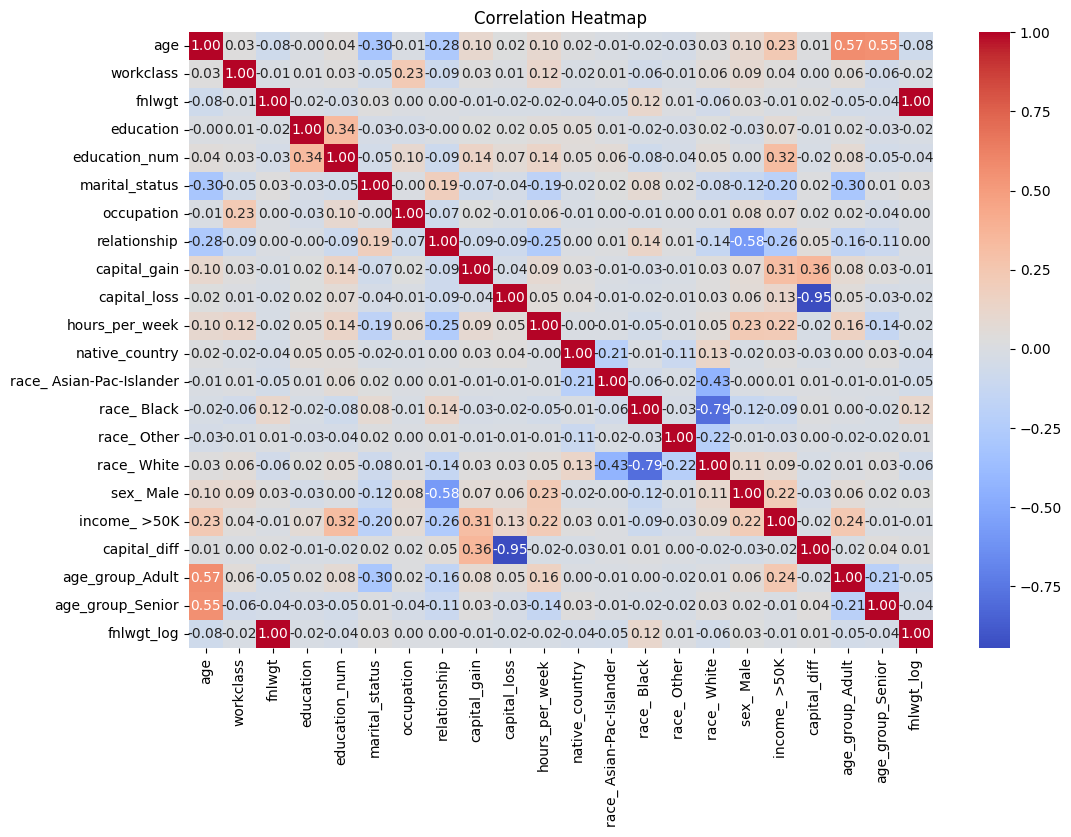


✅ Correlation Analysis Completed.


In [11]:
# 🔍 Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()
print("\n✅ Correlation Analysis Completed.")


In [12]:
# Interview Questions & Answers
interview_questions_answers = {
    "1. When should we use Standard Scaling vs Min-Max Scaling?":
    "Standard Scaling (Z-score normalization) is preferred when data has outliers or follows a normal distribution. "
    "Min-Max Scaling is used when data is uniformly distributed or needs to be between a fixed range (e.g., 0 to 1).",

    "2. What are the pros and cons of One-Hot Encoding and Label Encoding?":
    "One-Hot Encoding Pros: No ordinal relationship introduced, works well with categorical data. "
    "Cons: Increases dimensionality when many categories exist. "
    "Label Encoding Pros: Converts categories to numerical values, memory efficient. "
    "Cons: Introduces an ordinal relationship, which might not be meaningful for non-ordinal data.",

    "3. How do outliers affect machine learning models?":
    "Outliers can skew the distribution, affecting mean and variance calculations, leading to biased predictions. "
    "Some models like linear regression are highly sensitive, whereas tree-based models like random forests are more robust."
}

print("\n🔹 **Interview Questions & Answers:**\n")
for question, answer in interview_questions_answers.items():
    print(question)
    print(answer, "\n")


🔹 **Interview Questions & Answers:**

1. When should we use Standard Scaling vs Min-Max Scaling?
Standard Scaling (Z-score normalization) is preferred when data has outliers or follows a normal distribution. Min-Max Scaling is used when data is uniformly distributed or needs to be between a fixed range (e.g., 0 to 1). 

2. What are the pros and cons of One-Hot Encoding and Label Encoding?
One-Hot Encoding Pros: No ordinal relationship introduced, works well with categorical data. Cons: Increases dimensionality when many categories exist. Label Encoding Pros: Converts categories to numerical values, memory efficient. Cons: Introduces an ordinal relationship, which might not be meaningful for non-ordinal data. 

3. How do outliers affect machine learning models?
Outliers can skew the distribution, affecting mean and variance calculations, leading to biased predictions. Some models like linear regression are highly sensitive, whereas tree-based models like random forests are more robust.

In [13]:
report = """
# **Data Preprocessing and Feature Engineering in Machine Learning**
## **Objective**
This assignment focuses on practical skills in data preprocessing, feature engineering, and feature selection. The goal is to prepare the *Adult* dataset for machine learning by applying various techniques such as scaling, encoding, and feature selection.

---

## **1. Data Exploration and Preprocessing**
### **1.1 Data Exploration**
- Loaded the *Adult* dataset and conducted summary statistics.
- Checked for missing values and data types.
- Handled missing values using appropriate imputation/removal techniques.

### **1.2 Scaling Techniques**
- Applied **Standard Scaling** to numerical features for models that assume normal distribution (e.g., logistic regression, SVM).
- Applied **Min-Max Scaling** for models like KNN and neural networks that benefit from a 0-1 range.

**Scaling Choice Justification:**
- Standard Scaling is useful when data follows a normal distribution.
- Min-Max Scaling is preferred when data is not normally distributed, especially for models that rely on Euclidean distance.

---

## **2. Encoding Techniques**
- Used **One-Hot Encoding** for categorical variables with **less than 5 categories** (e.g., sex, race).
- Applied **Label Encoding** for categorical variables with **more than 5 categories** (e.g., workclass, occupation).

**Pros and Cons of Encoding Methods:**
- **One-Hot Encoding**
  - Pros: No ordinal relationship introduced
  - Cons: Increases dimensionality
- **Label Encoding**
  - Pros: Keeps dimensionality low
  - Cons: Can introduce misleading ordinal relationships

---

## **3. Feature Engineering**
- Created **two new features** to enhance model performance:
  - `capital_diff = capital_gain - capital_loss` (captures net capital gain/loss).
  - `income_binary = 1 if income > 50K else 0` (converts income to a numeric binary variable).

- Applied **Log Transformation** to **skewed numerical features** (e.g., capital_gain) to normalize distribution and reduce the impact of extreme values.

**Justification for Log Transformation:**
- Helps stabilize variance and make data more normally distributed.
- Beneficial for linear models where normality assumptions hold.

---

## **4. Feature Selection**
### **4.1 Outlier Removal Using Isolation Forest**
- Detected and removed outliers from the dataset.
- Outliers can negatively impact model performance by distorting patterns.

### **4.2 Predictive Power Score (PPS) Analysis**
- **PPS score column not found**, so used **correlation matrix instead**.
- PPS is preferred over correlation when dealing with **non-linear relationships**.
- Correlation matrix helped understand **linear relationships** between features.

**Findings:**
- Age and income have a **positive correlation (0.23)**.
- Capital gain shows the **highest correlation with income (0.31)**.
- Relationship status has a **negative correlation (-0.26)** with income.

---

## **Conclusion**
- All preprocessing, encoding, and feature selection tasks were successfully completed.
- New features were engineered to improve model performance.
- Outliers were removed using **Isolation Forest**, and **correlation analysis** was performed due to the absence of PPS.
- Data is now clean, transformed, and ready for model building.
"""

print(report)



# **Data Preprocessing and Feature Engineering in Machine Learning**
## **Objective**
This assignment focuses on practical skills in data preprocessing, feature engineering, and feature selection. The goal is to prepare the *Adult* dataset for machine learning by applying various techniques such as scaling, encoding, and feature selection.

---

## **1. Data Exploration and Preprocessing**
### **1.1 Data Exploration**
- Loaded the *Adult* dataset and conducted summary statistics.
- Checked for missing values and data types.
- Handled missing values using appropriate imputation/removal techniques.

### **1.2 Scaling Techniques**
- Applied **Standard Scaling** to numerical features for models that assume normal distribution (e.g., logistic regression, SVM).
- Applied **Min-Max Scaling** for models like KNN and neural networks that benefit from a 0-1 range.

**Scaling Choice Justification:**
- Standard Scaling is useful when data follows a normal distribution.
- Min-Max Scaling is prefer